# Quick Start with Dynap-SE2

## Imports

In [1]:
# - Switch off warnings
import warnings

warnings.filterwarnings("ignore")

from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSEvent, TSContinuous

# Utils
from typing import Optional, Tuple, Any
from rockpool.nn.modules.module import ModuleBase
import numpy as np
from tqdm import tqdm
import time

# - Plotting and config
import matplotlib.pyplot as plt

# - Jax imports
import jax
from jax.experimental.optimizers import adam
from rockpool.training import jax_loss as jl

# - Rockpool imports
from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
)


# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12

from IPython.display import Image

In [2]:
T = 4000
f_in = 0.04
dt = 1e-3
Nin = 10
Nout = 2
plt.rcParams["figure.figsize"] = [5.6, 2.8]

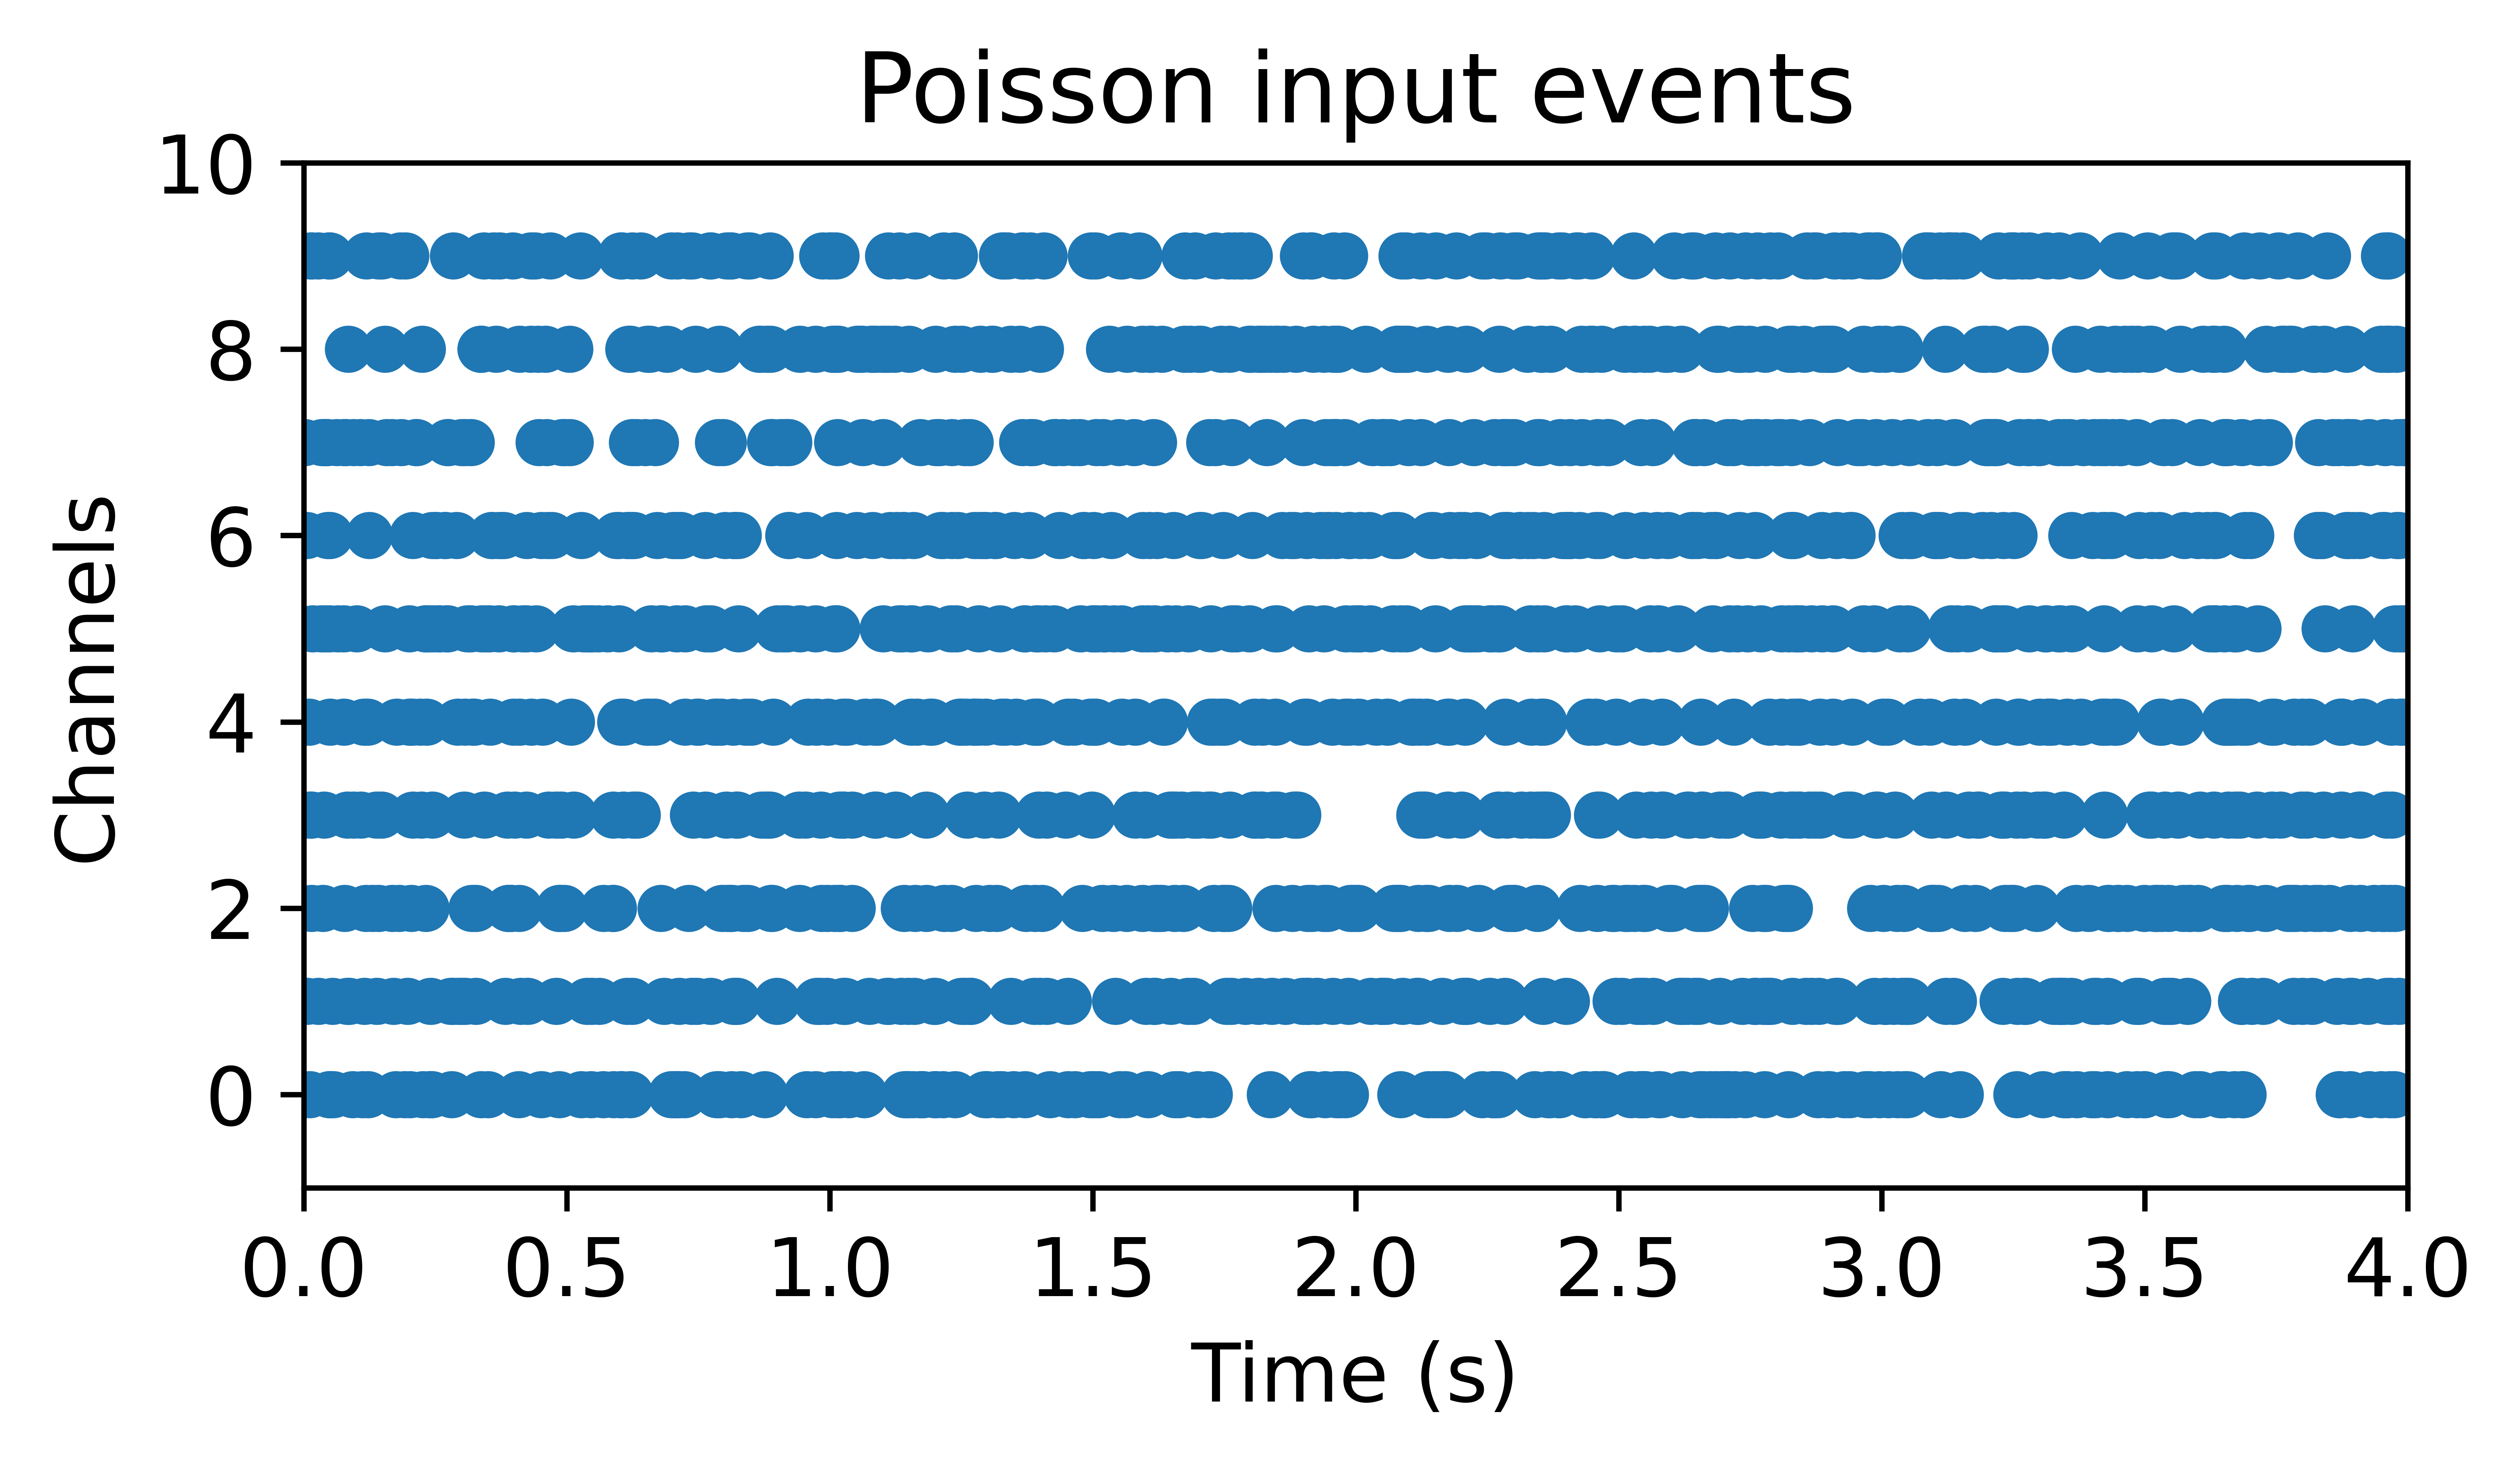

In [3]:
np.random.seed(1995)
input_spikes = np.random.rand(1, T, Nin) < f_in
TSEvent.from_raster(input_spikes[0], dt, name = 'Poisson input events').plot();

## Step 1 : Build a Network


In [4]:
net = Sequential(LinearJax((Nin,Nout), has_bias=False), DynapSim(Nout, has_rec=True, Iscale=1e-7))

## Step 2 : Simulate


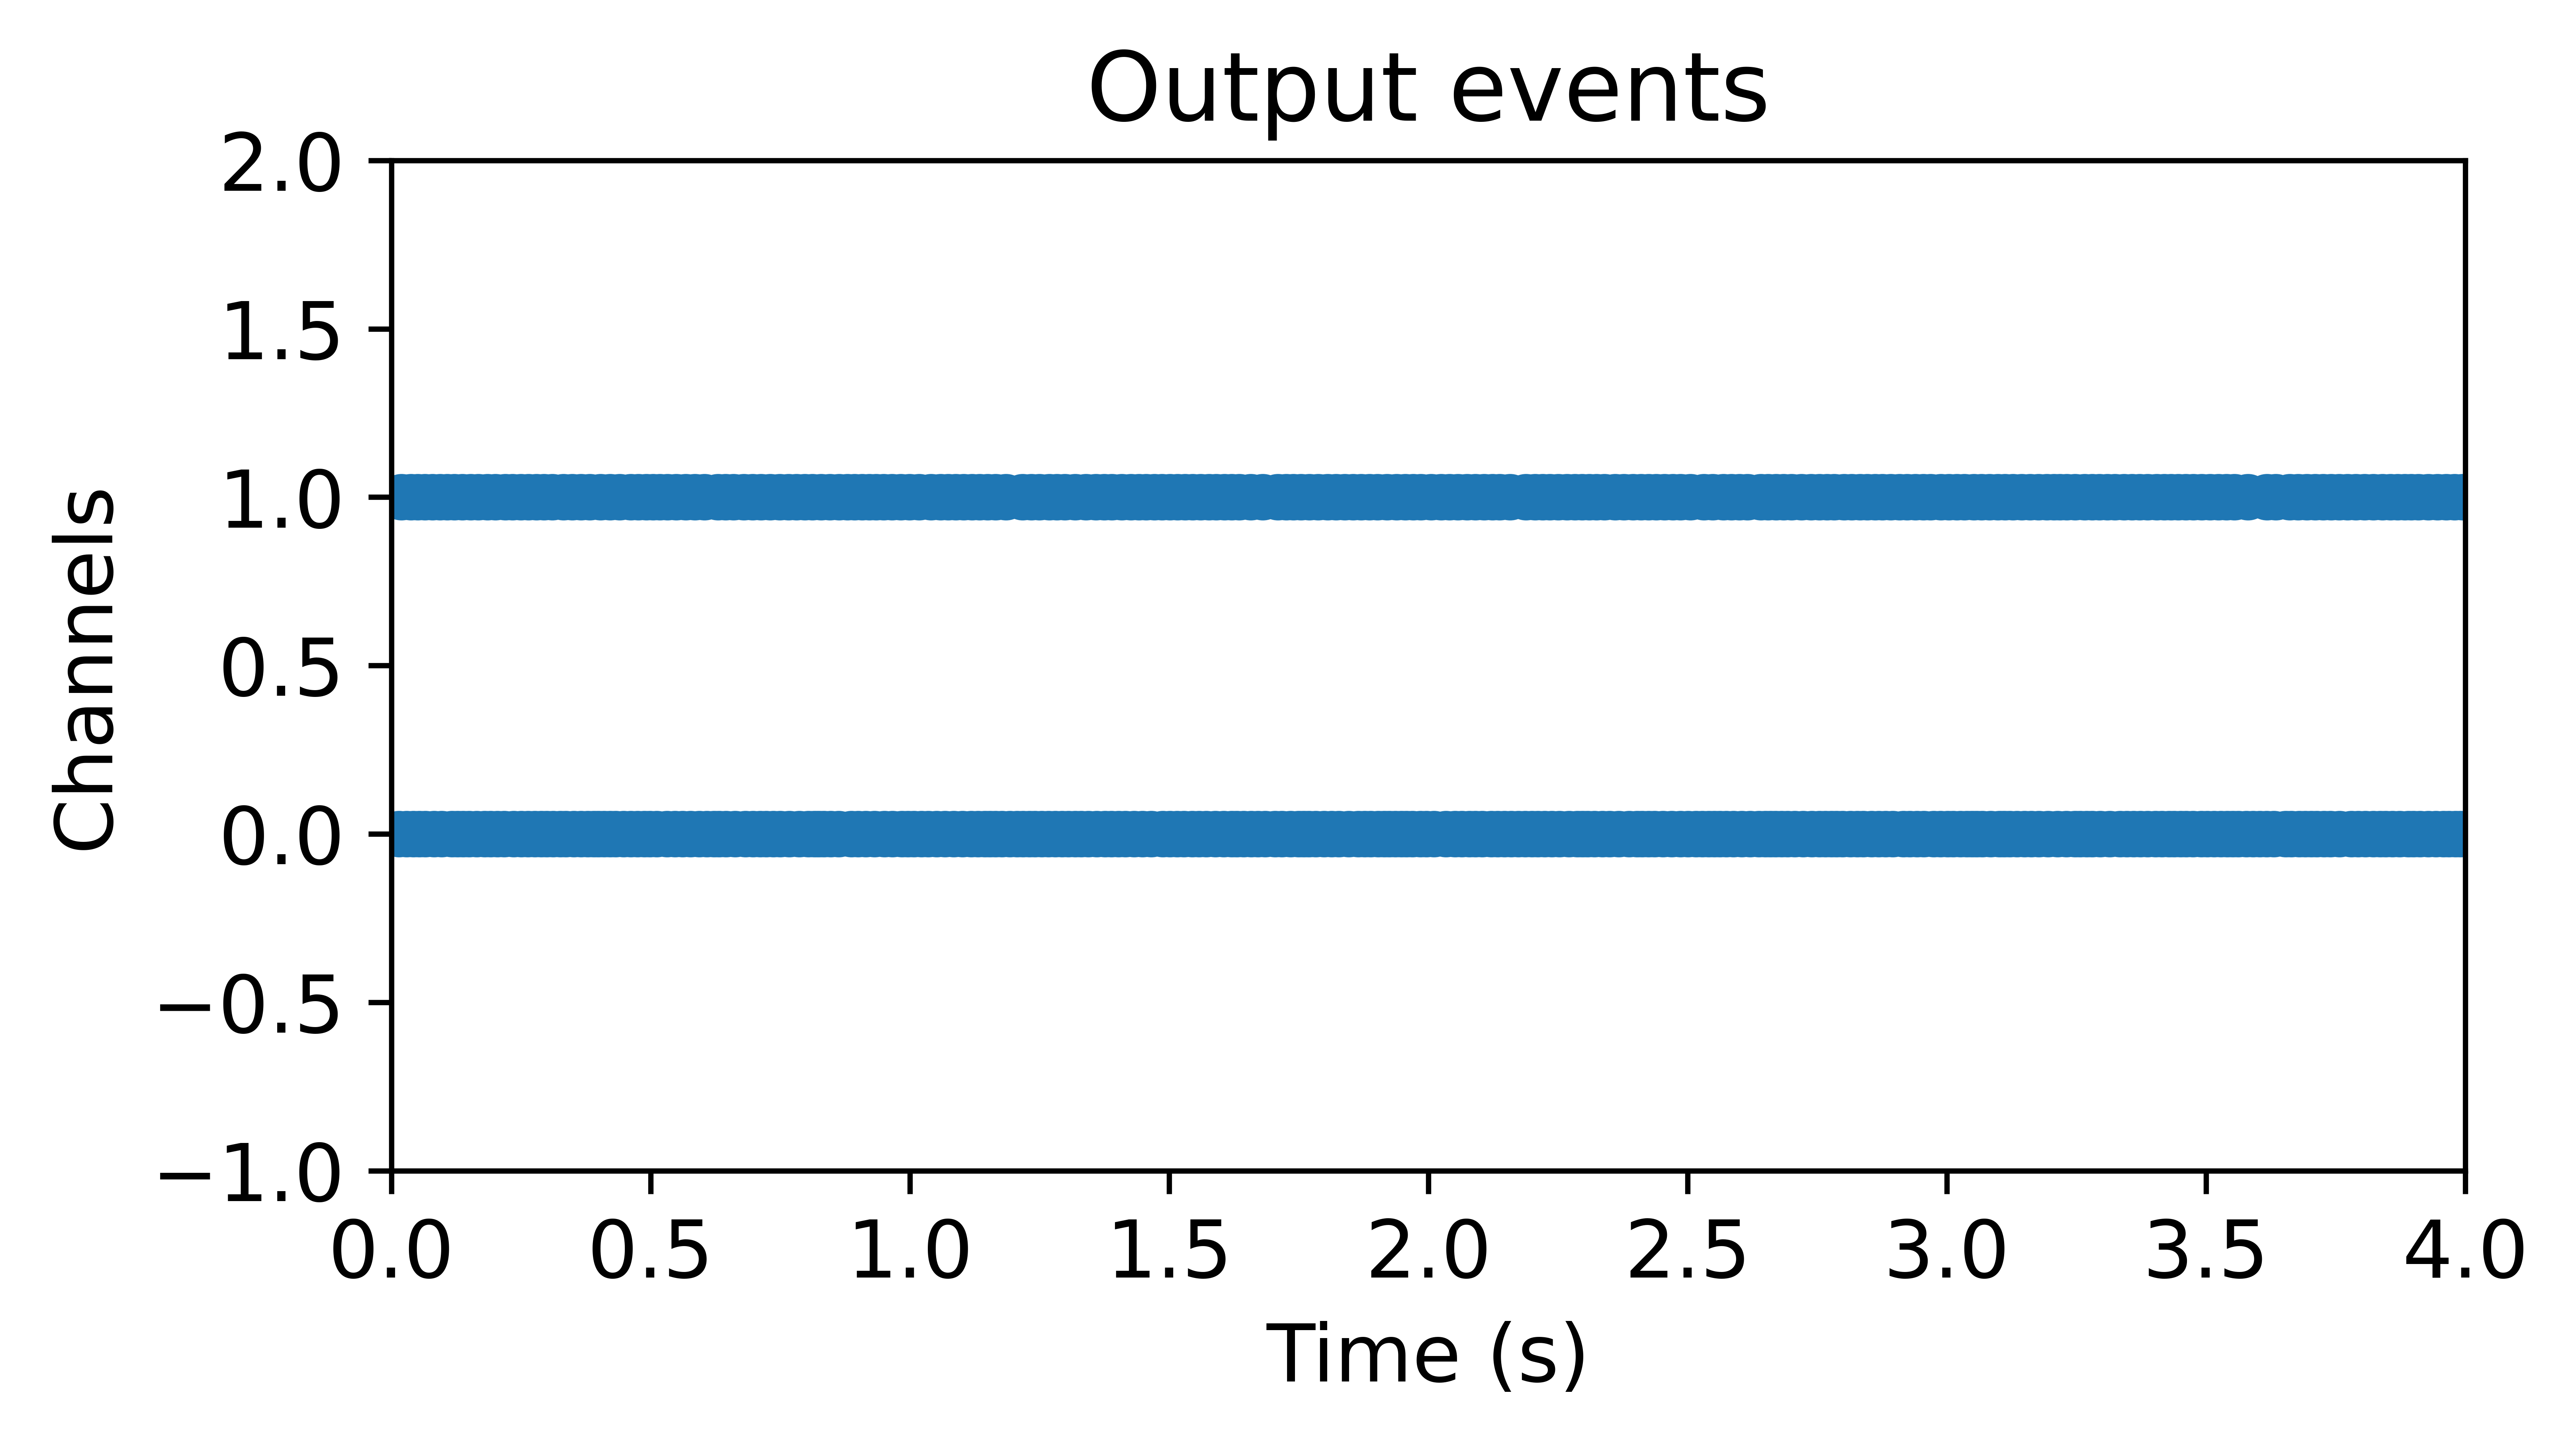

In [5]:
net.reset_state()
out, state, rec = net(input_spikes)
TSEvent.from_raster(out[0], dt, name = 'Output events').plot();

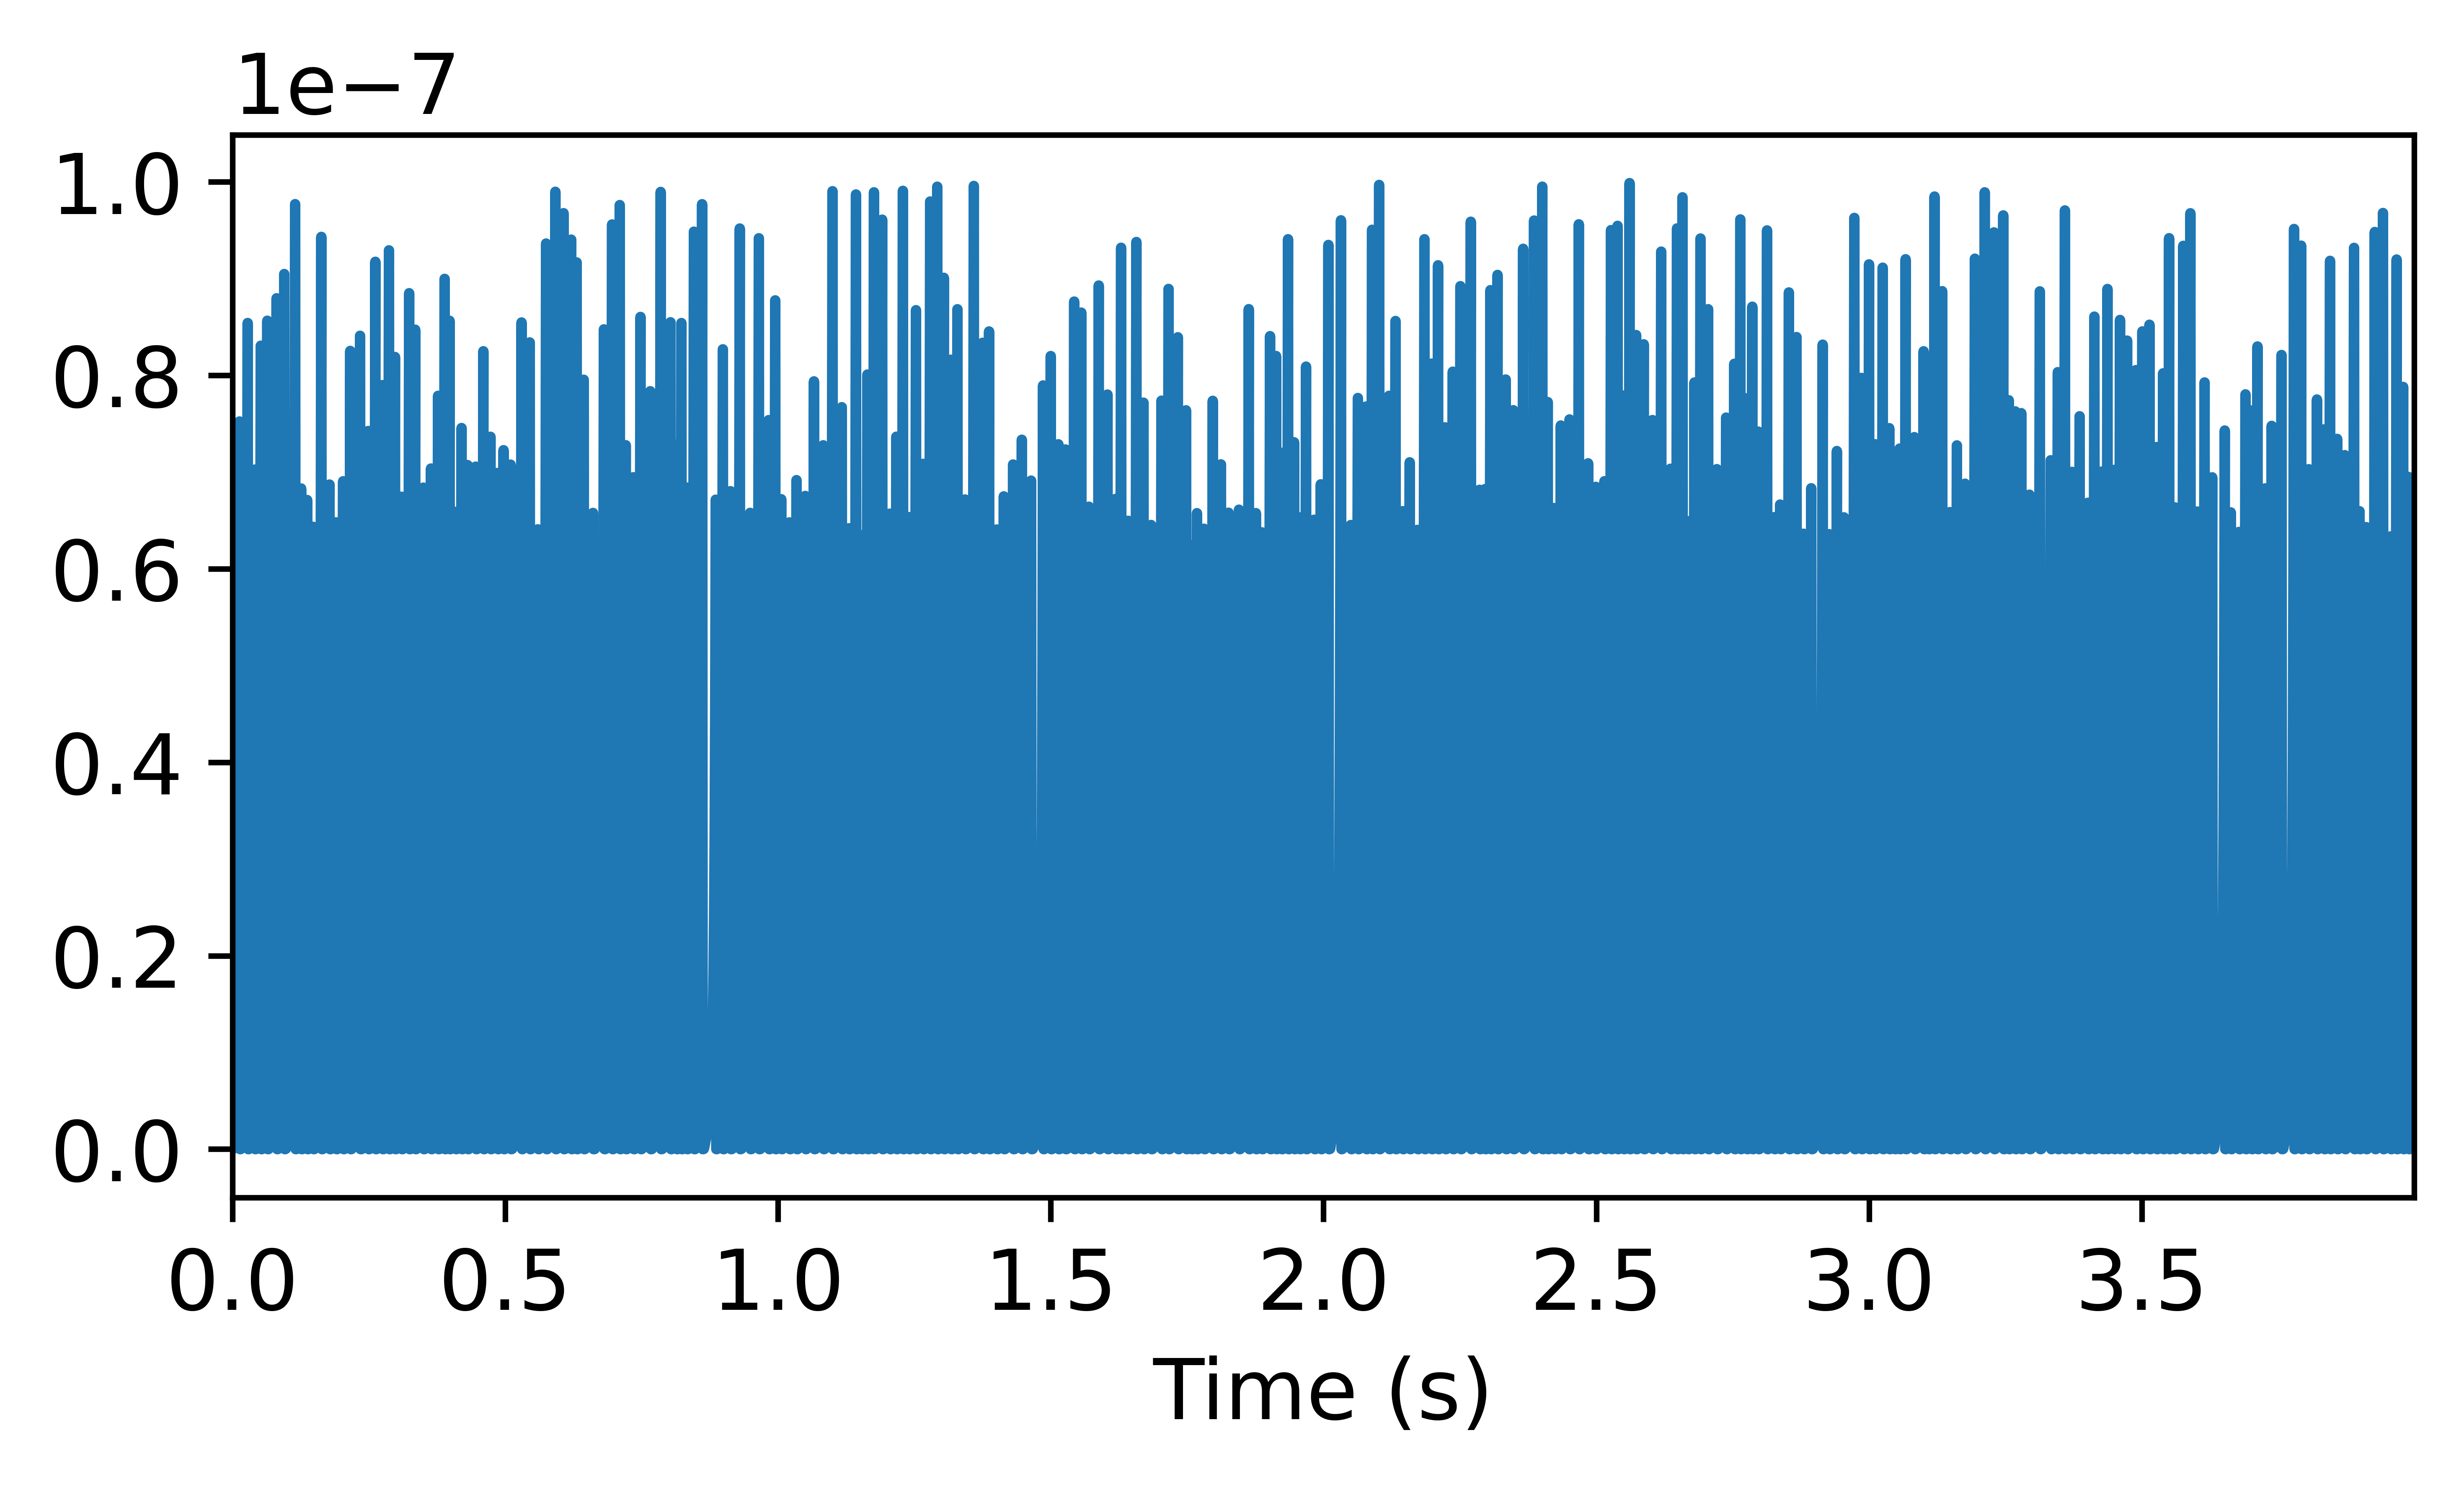

In [6]:
TSContinuous.from_clocked(rec['1_DynapSim']['imem'][0,:,0], dt=dt).plot()

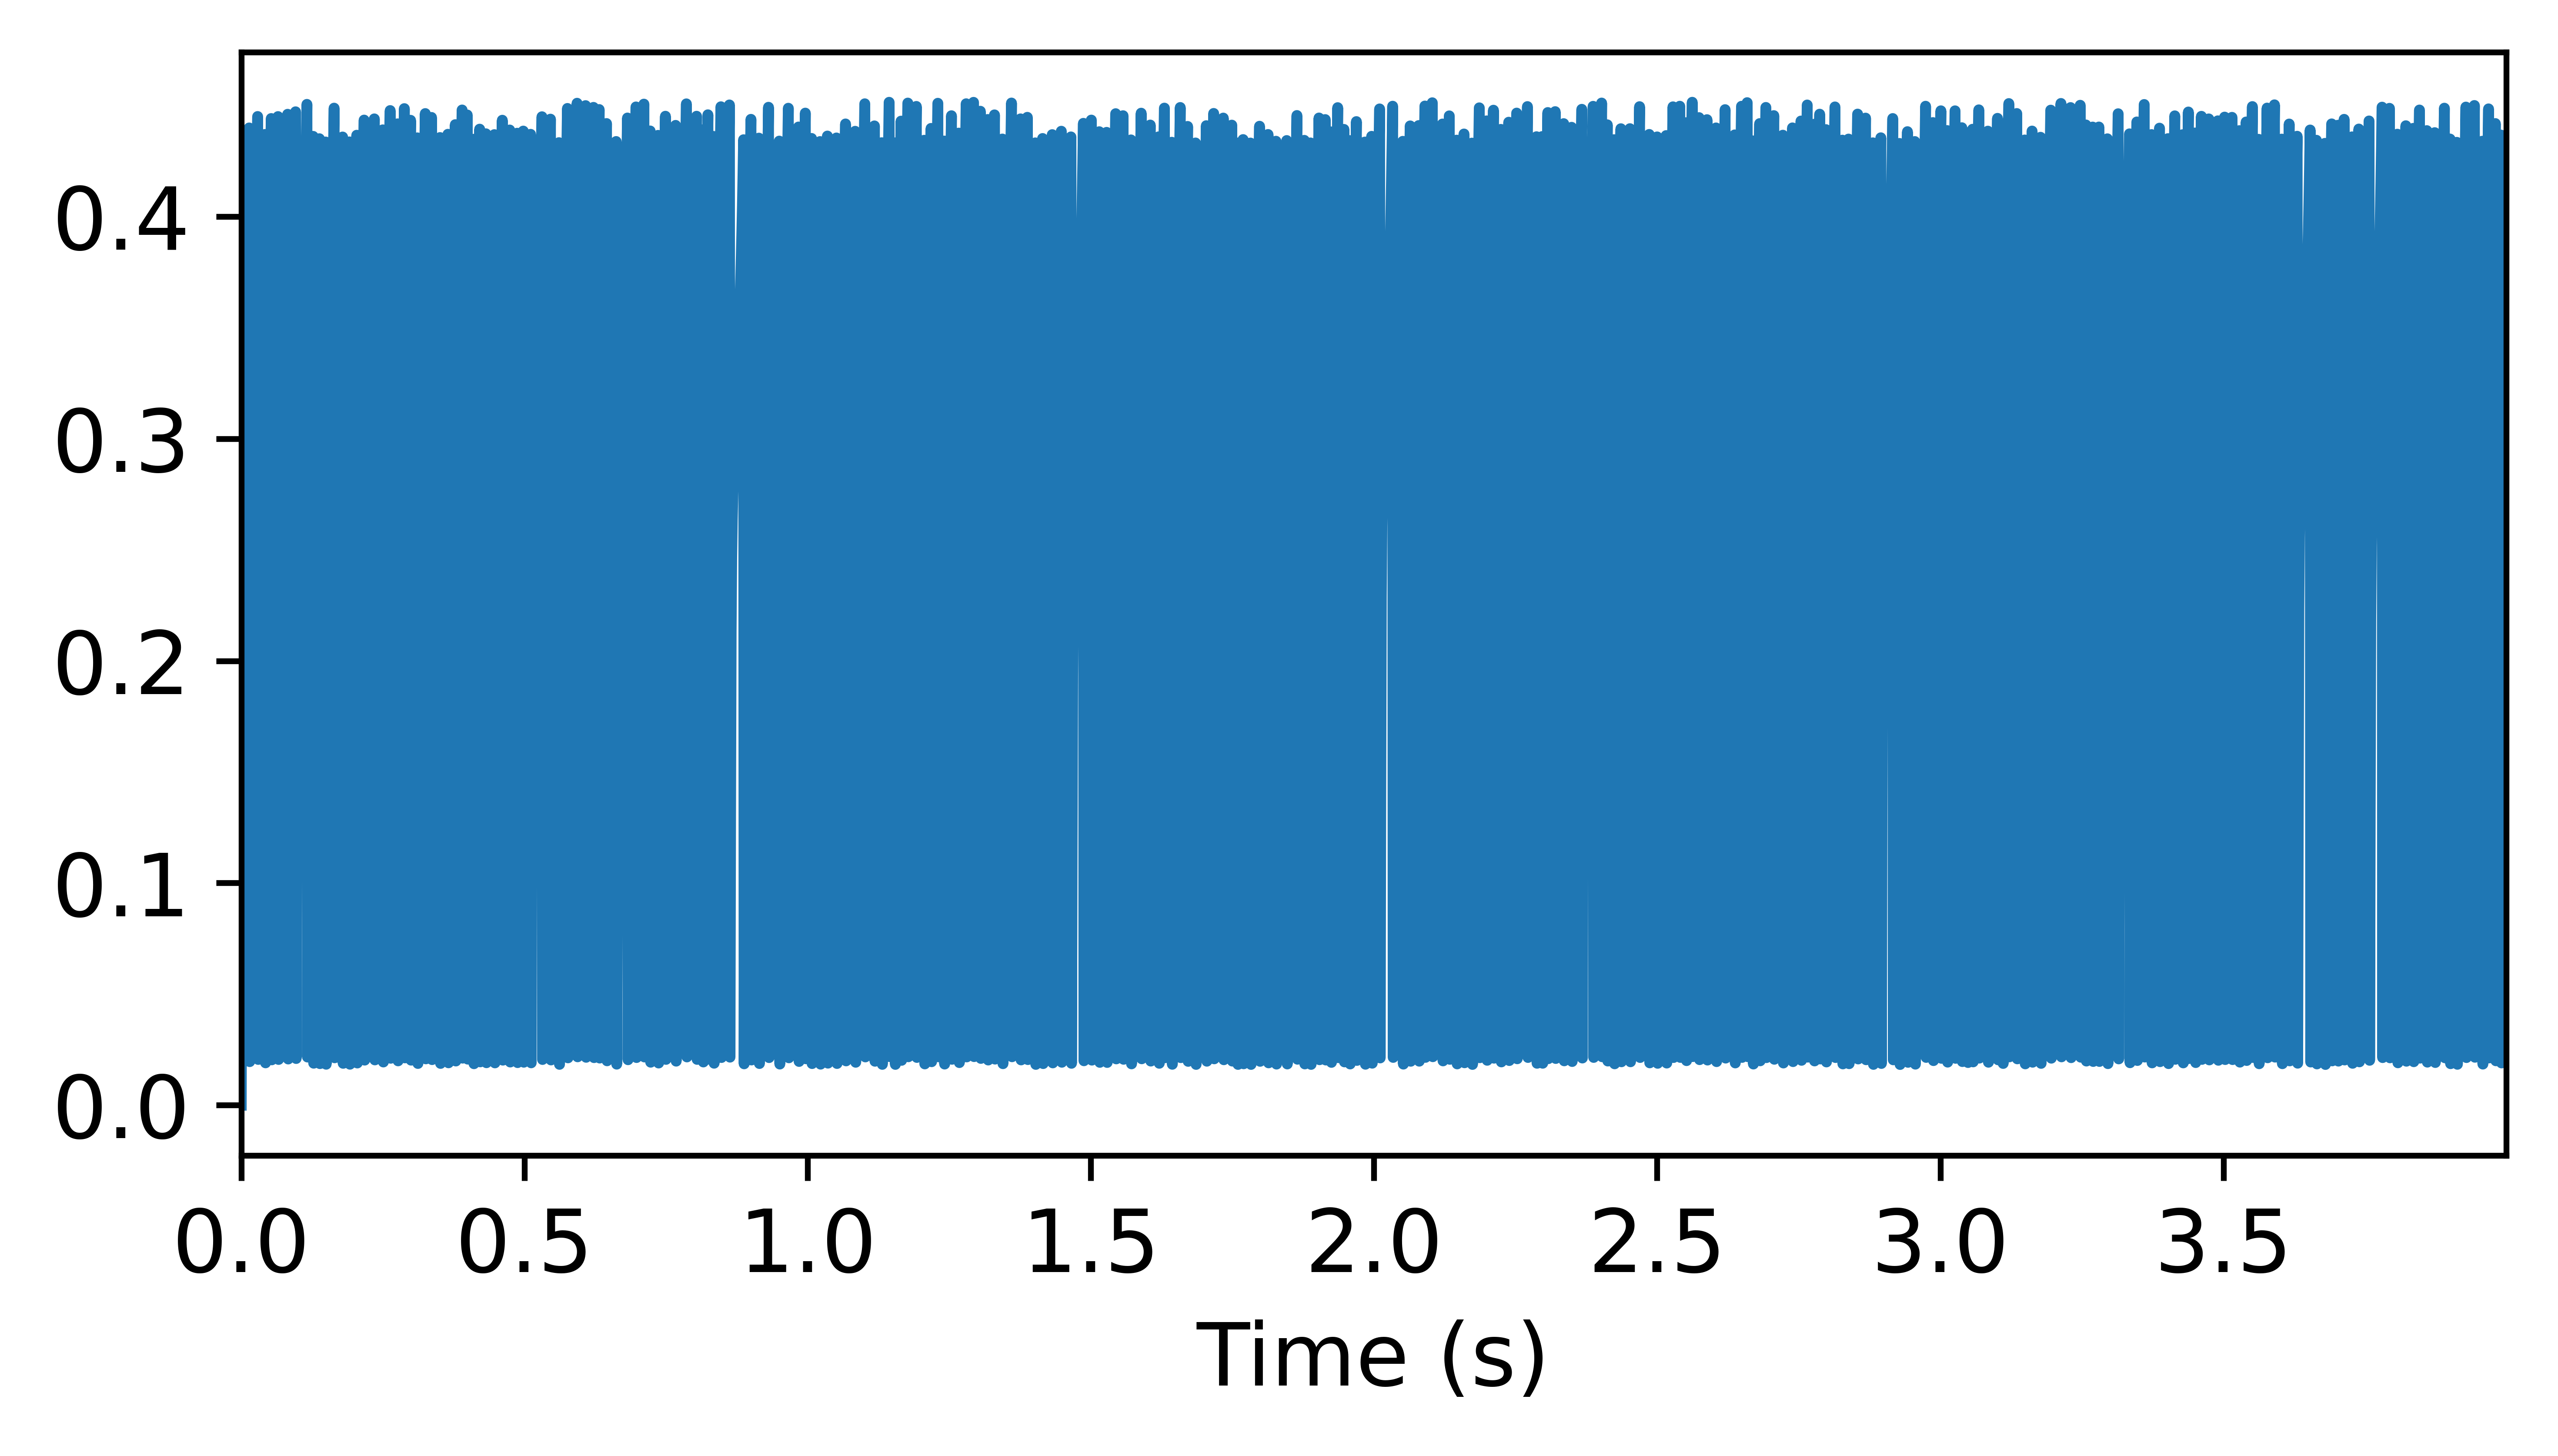

In [7]:
TSContinuous.from_clocked(rec['1_DynapSim']['vmem'][0,:,0], dt=dt).plot()

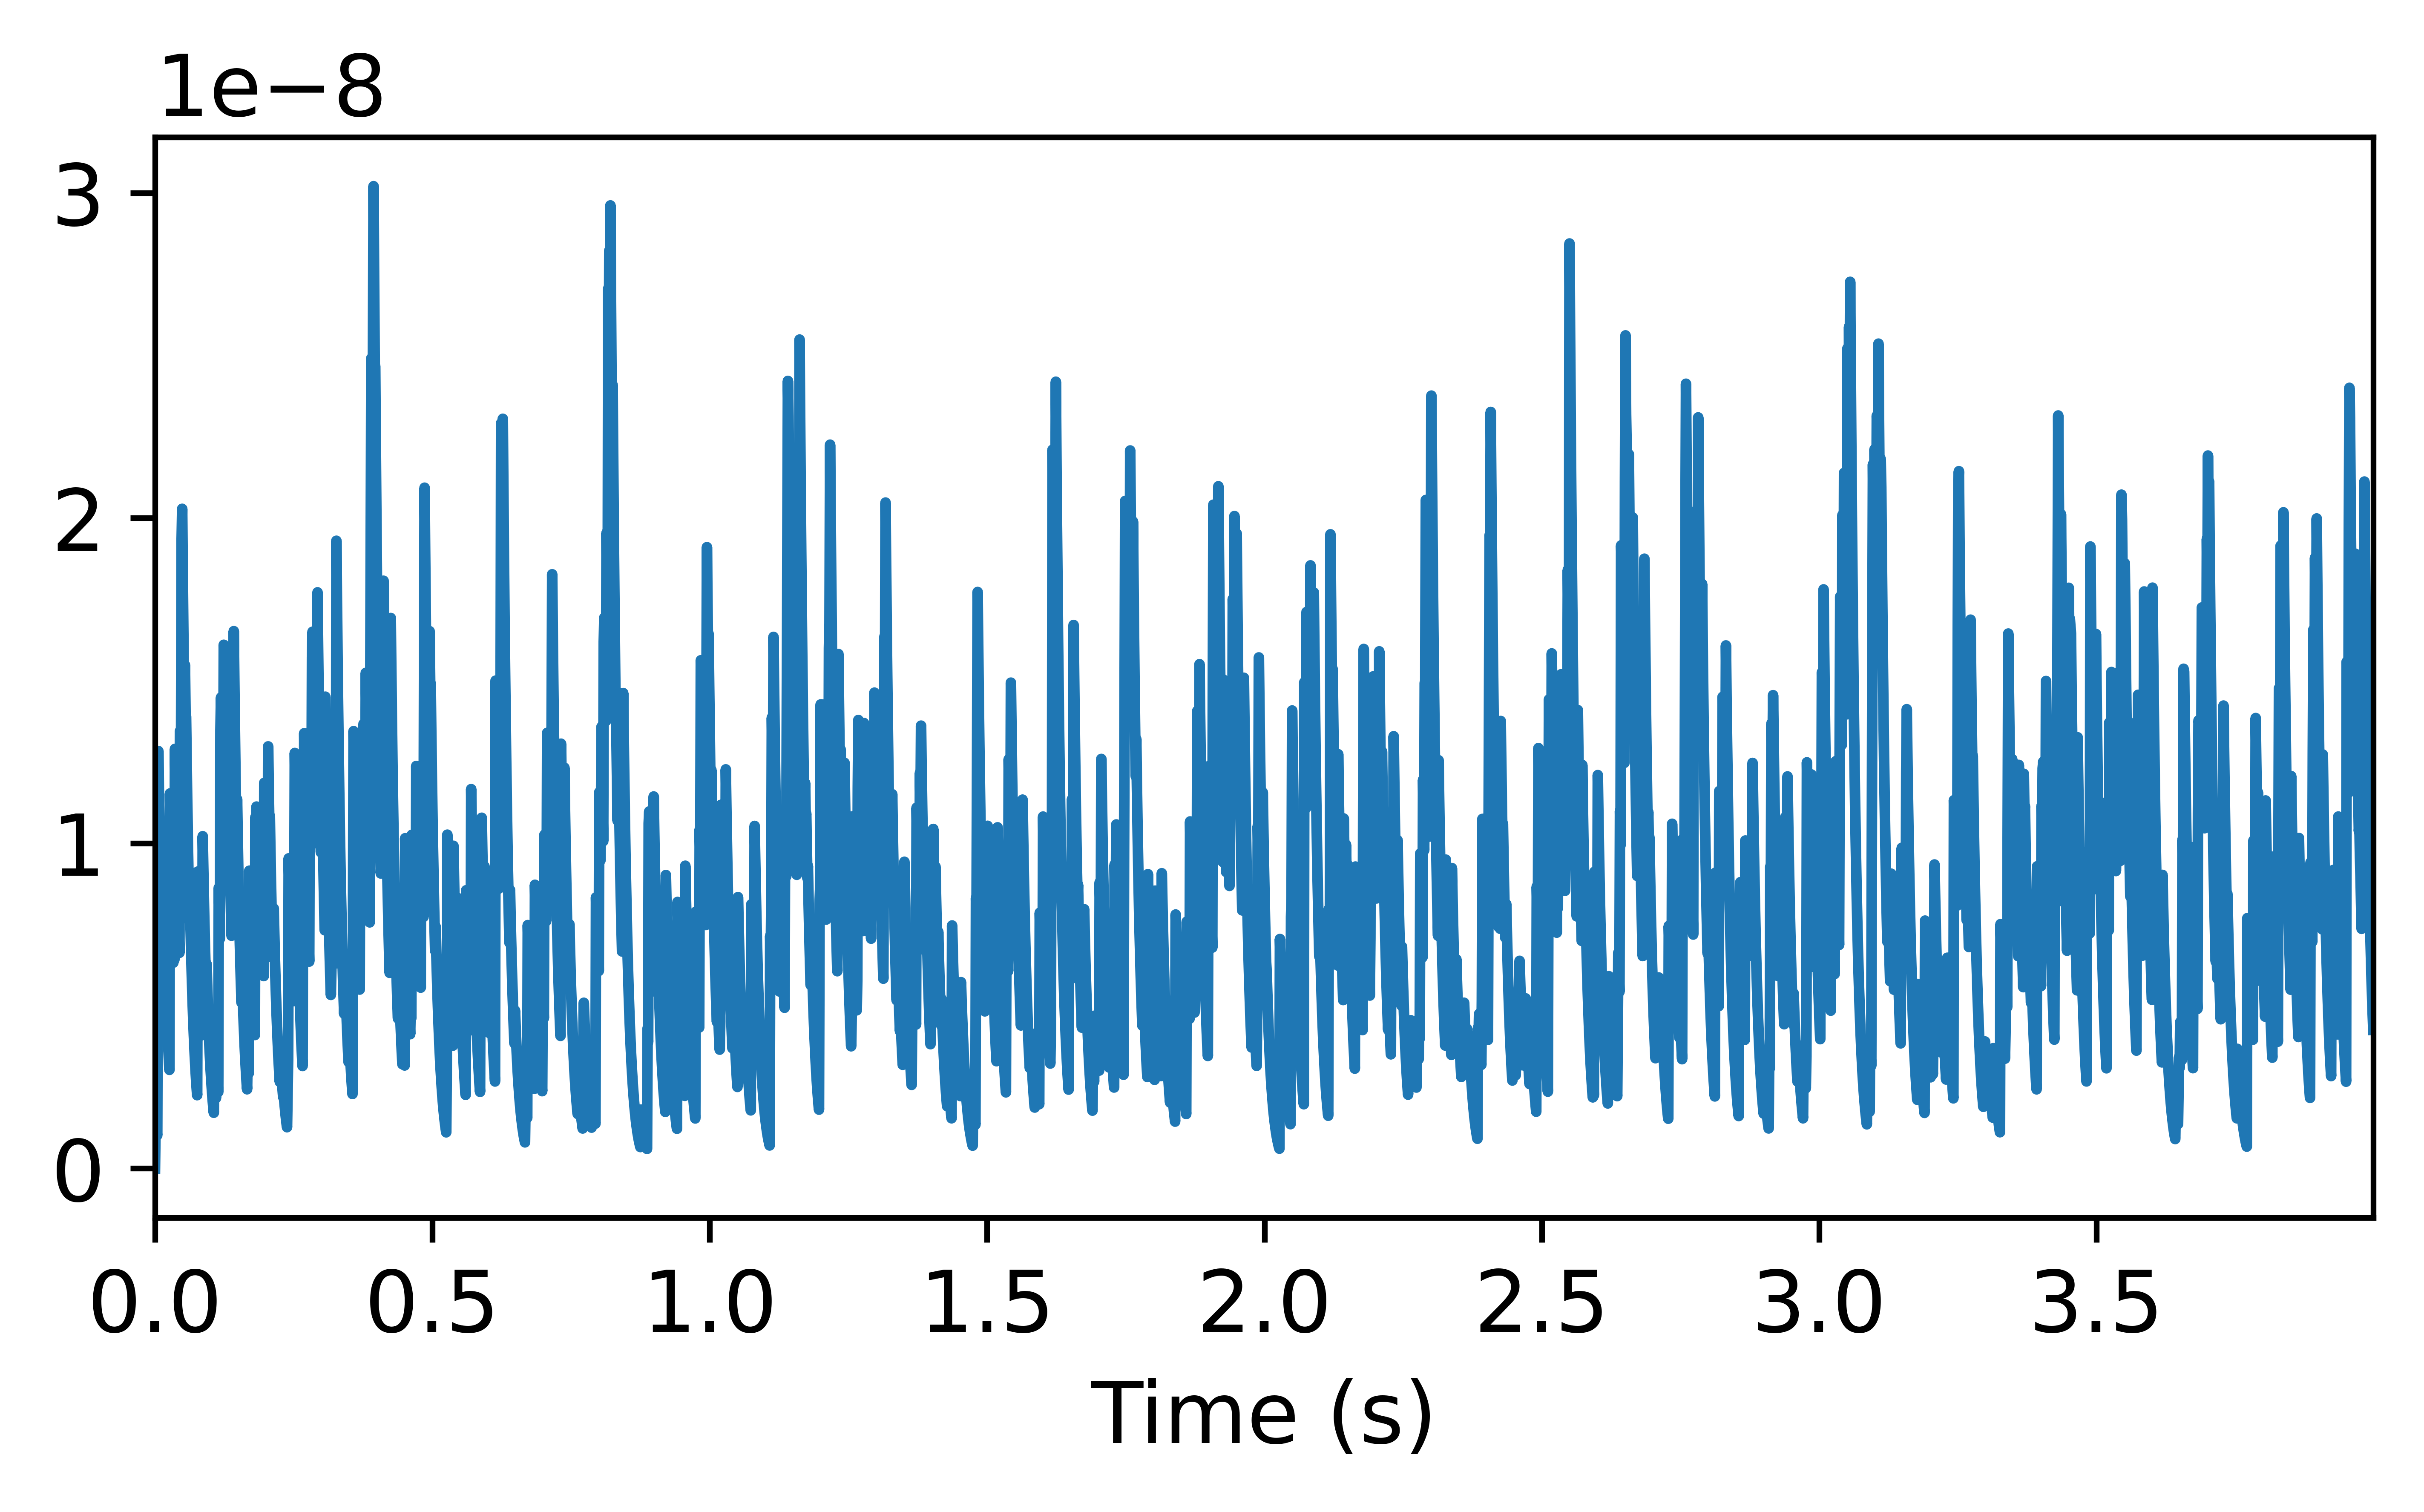

In [8]:
TSContinuous.from_clocked(rec['1_DynapSim']['isyn'][0,:,0], dt=dt).plot()

## Step 5 : Map the Network to a Hardware Specification

In [9]:
spec = mapper(net.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__6081018080" with 10 input nodes -> 2 output nodes,
 'weights_in': array([[ 0.12133525, -0.41226083],
        [ 0.65083105, -0.62124833],
        [ 0.70935743, -0.74037402],
        [-0.48581402,  0.08792787],
        [-0.40054067, -0.33457324],
        [-0.67688198, -0.49509106],
        [ 0.60785807,  0.13371782],
        [ 0.13747613,  0.33151453],
        [-0.55723176,  0.06575116],
        [ 0.22839713, -0.15115241]]),
 'weights_rec': array([[-0.33298385, -0.19116156],
        [-1.2623904 ,  0.46005967]], dtype=float32),
 'Iscale': 1e-07,
 'n_cluster': 1,
 'core_map': array([0., 0.]),
 'n_neuron': 2,
 'unclustered': {'Ispkthr': [1.0000000116860974e-07, 1.0000000116860974e-07],
  'If_nmda': [4.999999980020986e-13, 4.999999980020986e-13],
  'Ipulse_ahp': [0.3499999940395355, 0.3499999940395355],
  'Itau_ahp': [2.8368795160216287e-11, 2.8368795160216287e-11],
  'Iw_ahp': [0.0, 0.0],
  'Igain_ahp': [2.8368795160216287e-11, 2.8368795160216287

## Step 6 : Quantize Weights

In [10]:
spec.update(autoencoder_quantization(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__6081018080" with 10 input nodes -> 2 output nodes,
 'weights_in': [array([[ 0,  6],
         [ 3,  3],
         [ 3, 13],
         [ 9,  0],
         [ 2,  2],
         [ 7, 10],
         [ 3,  4],
         [ 8,  1],
         [ 3,  0],
         [ 8,  0]], dtype=int32)],
 'weights_rec': [array([[ 4,  2],
         [15,  6]], dtype=int32)],
 'Iscale': 1e-07,
 'n_cluster': 1,
 'core_map': array([0., 0.]),
 'n_neuron': 2,
 'unclustered': {'Ispkthr': [1.0000000116860974e-07, 1.0000000116860974e-07],
  'If_nmda': [4.999999980020986e-13, 4.999999980020986e-13],
  'Ipulse_ahp': [0.3499999940395355, 0.3499999940395355],
  'Itau_ahp': [2.8368795160216287e-11, 2.8368795160216287e-11],
  'Iw_ahp': [0.0, 0.0],
  'Igain_ahp': [2.8368795160216287e-11, 2.8368795160216287e-11],
  'Iref': [1.049999975855087e-09, 1.049999975855087e-09],
  'Itau_mem': [5.319148767279902e-12, 5.319148767279902e-12],
  'Itau_syn': [8.687943420238042e-11, 8.687943420238042e-11],
  

## Step 7 : Obtain Hardware Config

In [11]:
config, input_channel_map = config_from_specification(**spec)

In [12]:
## Connect to device
se2_devices = find_dynapse_boards()

found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
else:
    se2 = DynapseSamna((10,2),se2_devices[0], config, input_channel_map)

ConnectionError: No samna device found plugged in to the system!

In [ ]:
def test_network(se2, spec, input_raster):

    out, state, rec = se2(input_raster, record=True)

    fig, axes = plt.subplots(2, 1)
    ticks = list(rec["channel_map"].keys())
    labels = [dest.tag for dest in rec["channel_map"].values()]

    plt.sca(axes[0])
    TSEvent.from_raster(
        input_raster, t_start=rec["start_time"], t_stop=rec["stop_time"]+se2.dt, dt=se2.dt
    ).plot()
    plt.xlabel("")

    plt.sca(axes[1])
    TSEvent.from_raster(
        out, t_start=rec["start_time"], t_stop=rec["stop_time"]+se2.dt, dt=se2.dt
    ).plot(color="firebrick")
    plt.title("Device Output")
    plt.yticks(ticks, labels)
    plt.tight_layout()
    print(f"Rate = {np.sum(out)}")

Rate = 42.0


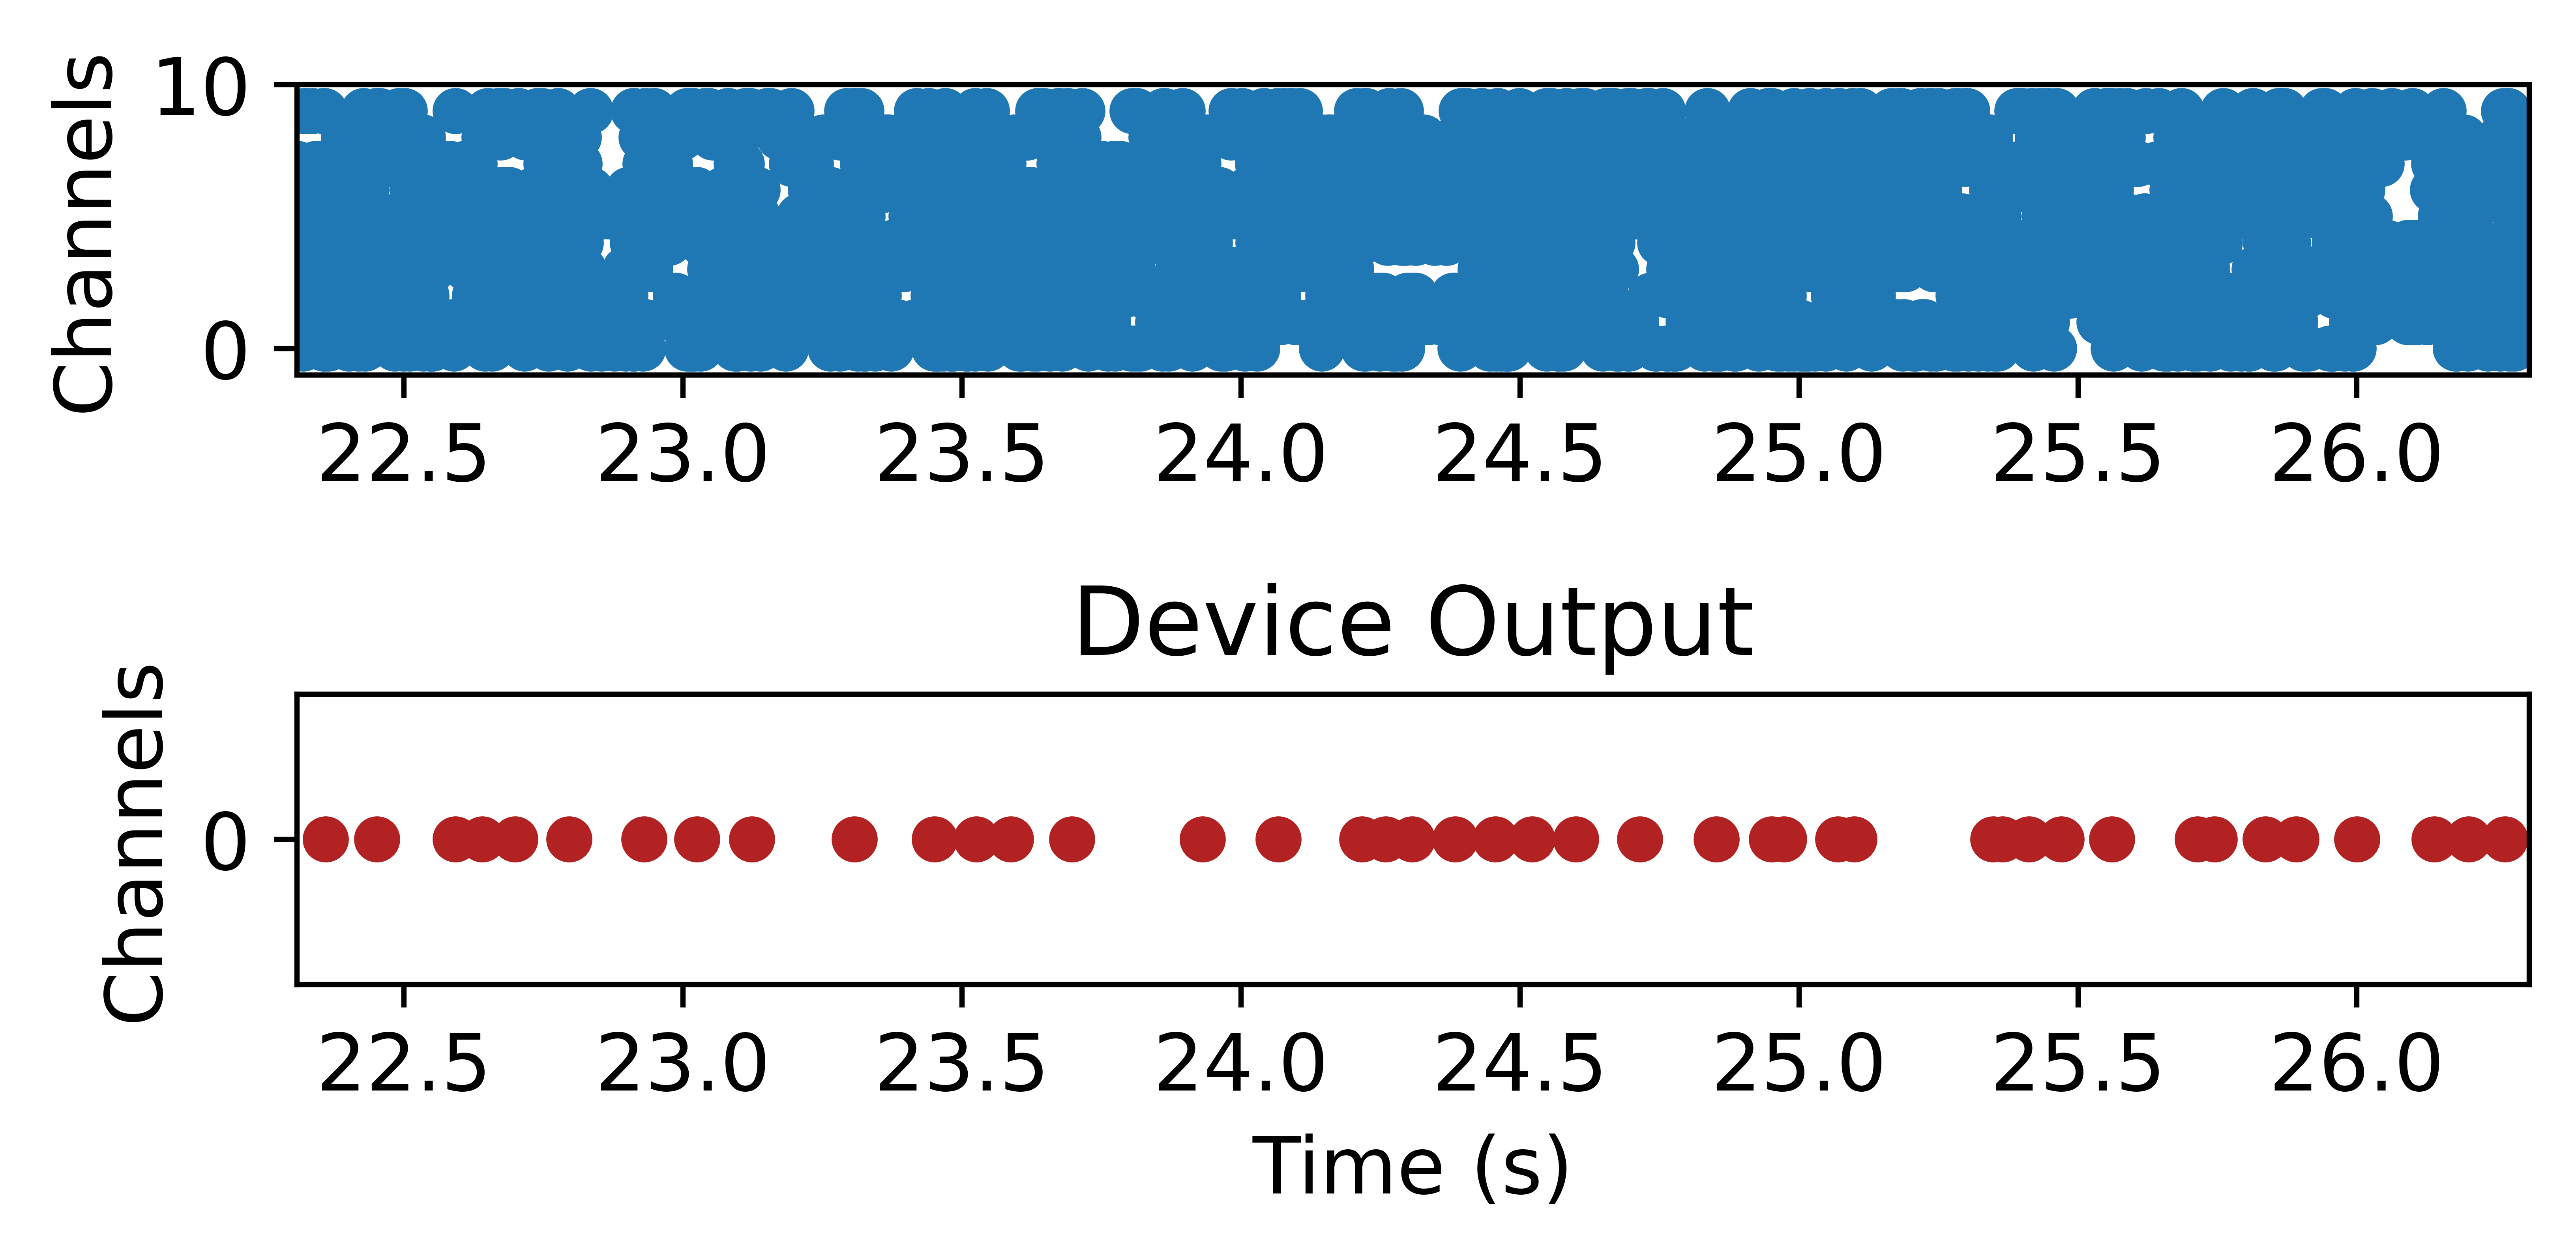

In [ ]:
test_network(se2, spec, input_spikes[0])